In [1]:
import os
os.chdir('/grid_mnt/data_cms_upgrade/biriukov/TICL_Validation/python')
from validation.DataFile import *
from typing import List, Union
import re

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
#plt.rcParams['text.usetex'] = True
import mplhep as hep
plt.style.use(hep.style.CMS)
filepath = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_5_30/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'

tfile = DataFile(filepath)

In [60]:
def makePlot(hist: List[Union[float, int]],
             bins: Union[List[float]],
             mode: str,
             plotLabel: str = None):
    # mode is Tracksters or Superclusters
    # define label for a histogram
    if mode == 'LC':
        label = '# LC'
    elif mode == 'Tracksters':
        label = '# Tracksters'
    elif mode == 'Superclusters':
        label = '# Superclusters'

    bin_centers = ((bins[1:] + bins[:-1])/2)
    bins = np.repeat(bins, 2)
    hist = np.concatenate([[0], np.repeat(hist, 2), [0]])

    fig, ax = plt.subplots()

    if plotLabel is None:
        ax.step(bins, hist, linewidth=2, where='post')
    else:
        ax.step(bins, hist, linewidth=2, label=plotLabel, where='post')

    # Create custom ticks
    if (mode == 'LC') and (type(bins) != int):
        ax.set_xticks(bin_centers[0::3], labels=range(1, len(bin_centers) + 1 , 3), rotation=45, ha='right')

    if (mode != 'LC') and (type(bins) != int):
        ax.set_xticks(bin_centers, labels=range(1, len(bin_centers) + 1))
    ax.set_xlabel(label)
    ax.set_ylabel('Events')
    ax.set_ylim(0)
    ax.legend()
    hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
    hep.cms.lumitext("PU=0", ax=ax)

    hist_name = plotLabel.replace(' < ', '_').replace('$', '').replace('\\', '')\
                .replace('left(', '').replace('right)', '')        # create a name of a histogram from plotLabel
    hist_name = re.sub(r'text{.*?}', '', hist_name)
    path_to_save = f'plots/multiplicity/{mode}'
    os.makedirs(path_to_save, exist_ok=True)
    #plt.savefig(f'{path_to_save}/{hist_name}.png')

# Multiplicity

Multiplicity is a number of a certain object's constituents. For example:
1. LC multiplicity is a number of rechits in a given LC (Layer Cluster).
2. Trackster multiplicity is a number of LC in a given trackster.
3. Supercluster multiplicity is a number of tracksters in a given supercluster.

Extraction of data:
- Tracksters. branch_name = "ticlDumper/trackstersCLUE3DHigh", key = "vertices_z". Compute length of each array.

### Data processing for LC multiplicity

In [58]:
# Extract data
vertices = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="vertices_z")
barycenter_eta = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="barycenter_eta")
energy = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="raw_energy")
pt = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="raw_pt")
simToReco_CP = tfile.openArray(branch_name="ticlDumper/associations", key="tsCLUE3D_simToReco_CP")[:, 0]

# sort variables with simToReco
barycenter_eta = ak.flatten(barycenter_eta[simToReco_CP])
energy = ak.flatten(energy[simToReco_CP])
pt = ak.flatten(pt[simToReco_CP])

# extract combined LC multiplicity data
new_ver = ak.flatten(vertices[simToReco_CP])
multiplicity = np.array([len(shower) for shower in new_ver])

# Find boundary values for eta, energy and pT
eta_max = np.max(barycenter_eta)
eta_min = np.min(barycenter_eta)
e_max = np.max(energy)
e_min = np.min(energy)
pt_max = np.max(pt)
pt_min = np.min(pt)

# Define eta binning
eta_nbins = 4
eta_edges = np.linspace(eta_min, eta_max, eta_nbins + 1)

# Define energy binning
e_nbins = 4
e_edges = np.linspace(e_min, e_max, e_nbins + 1)

# Define pT binning
pt_nbins = 4
pt_edges = np.logspace(np.log10(pt_min + 1), np.log10(pt_max), pt_nbins + 1)

# combine edges [eta, e, pt]
edges = [eta_edges, e_edges, pt_edges]

# combine multiplicity data in bins of [eta, e, pt]
multiplicity_in_bins = [[], [], []]

binning_data = {
    0: barycenter_eta,
    1: energy,
    2: pt
}

for i, edges_array in enumerate(edges):
    for bin in range(len(edges_array) - 1):
        bin_map = np.array((binning_data[i] > edges_array[bin]) & (binning_data[i] < edges_array[bin + 1]))
        multiplicity_in_bins[i].append(multiplicity[bin_map])

# making histograms
nbins = np.max(multiplicity)
bin_edges = np.linspace(1, nbins, nbins)
hist_comb, _ = np.histogram(multiplicity, bin_edges)

hist_in_bins = [[[], []], [[], []], [[], []]]           # List of shape (3, 2, var), 3 = binning variables (eta, energy, pt), 2 = (hist, hist_bin_edges), var = number of bins in each binning variable

# Create binning for each variable [eta, energy, pT]
bin_edges_per_var = []
for i, edges_array in enumerate(edges):
    nbins = 0
    for bin in range(len(edges_array) - 1):
        nbins_cand = np.max(multiplicity_in_bins[i][bin])
        if nbins_cand > nbins:
            nbins = nbins_cand
    bin_edges = np.linspace(1, nbins, nbins)
    bin_edges_per_var.append(bin_edges)


for i, edges_array in enumerate(edges):
    bin_edges = bin_edges_per_var[i]
    for bin in range(len(edges_array) - 1):
        hist_per_bin, _ = np.histogram(multiplicity_in_bins[i][bin], bin_edges)
        hist_in_bins[i][0].append(hist_per_bin)
        hist_in_bins[i][1].append(bin_edges)

norm_hist_in_bins = [[[], []], [[], []], [[], []]]
for i, var in enumerate(hist_in_bins):
    hists = var[0]
    n_events_per_hist = np.array([np.sum(h) for h in hists])
    weights = n_events_per_hist[0]/n_events_per_hist

    norm_hists = [hists[i]*weights[i] for i in range(len(weights))]
    for h in norm_hists:
        norm_hist_in_bins[i][0].append(h)
    for b in var[1]:
        norm_hist_in_bins[i][1].append(b)

### Plotting LC multiplicity

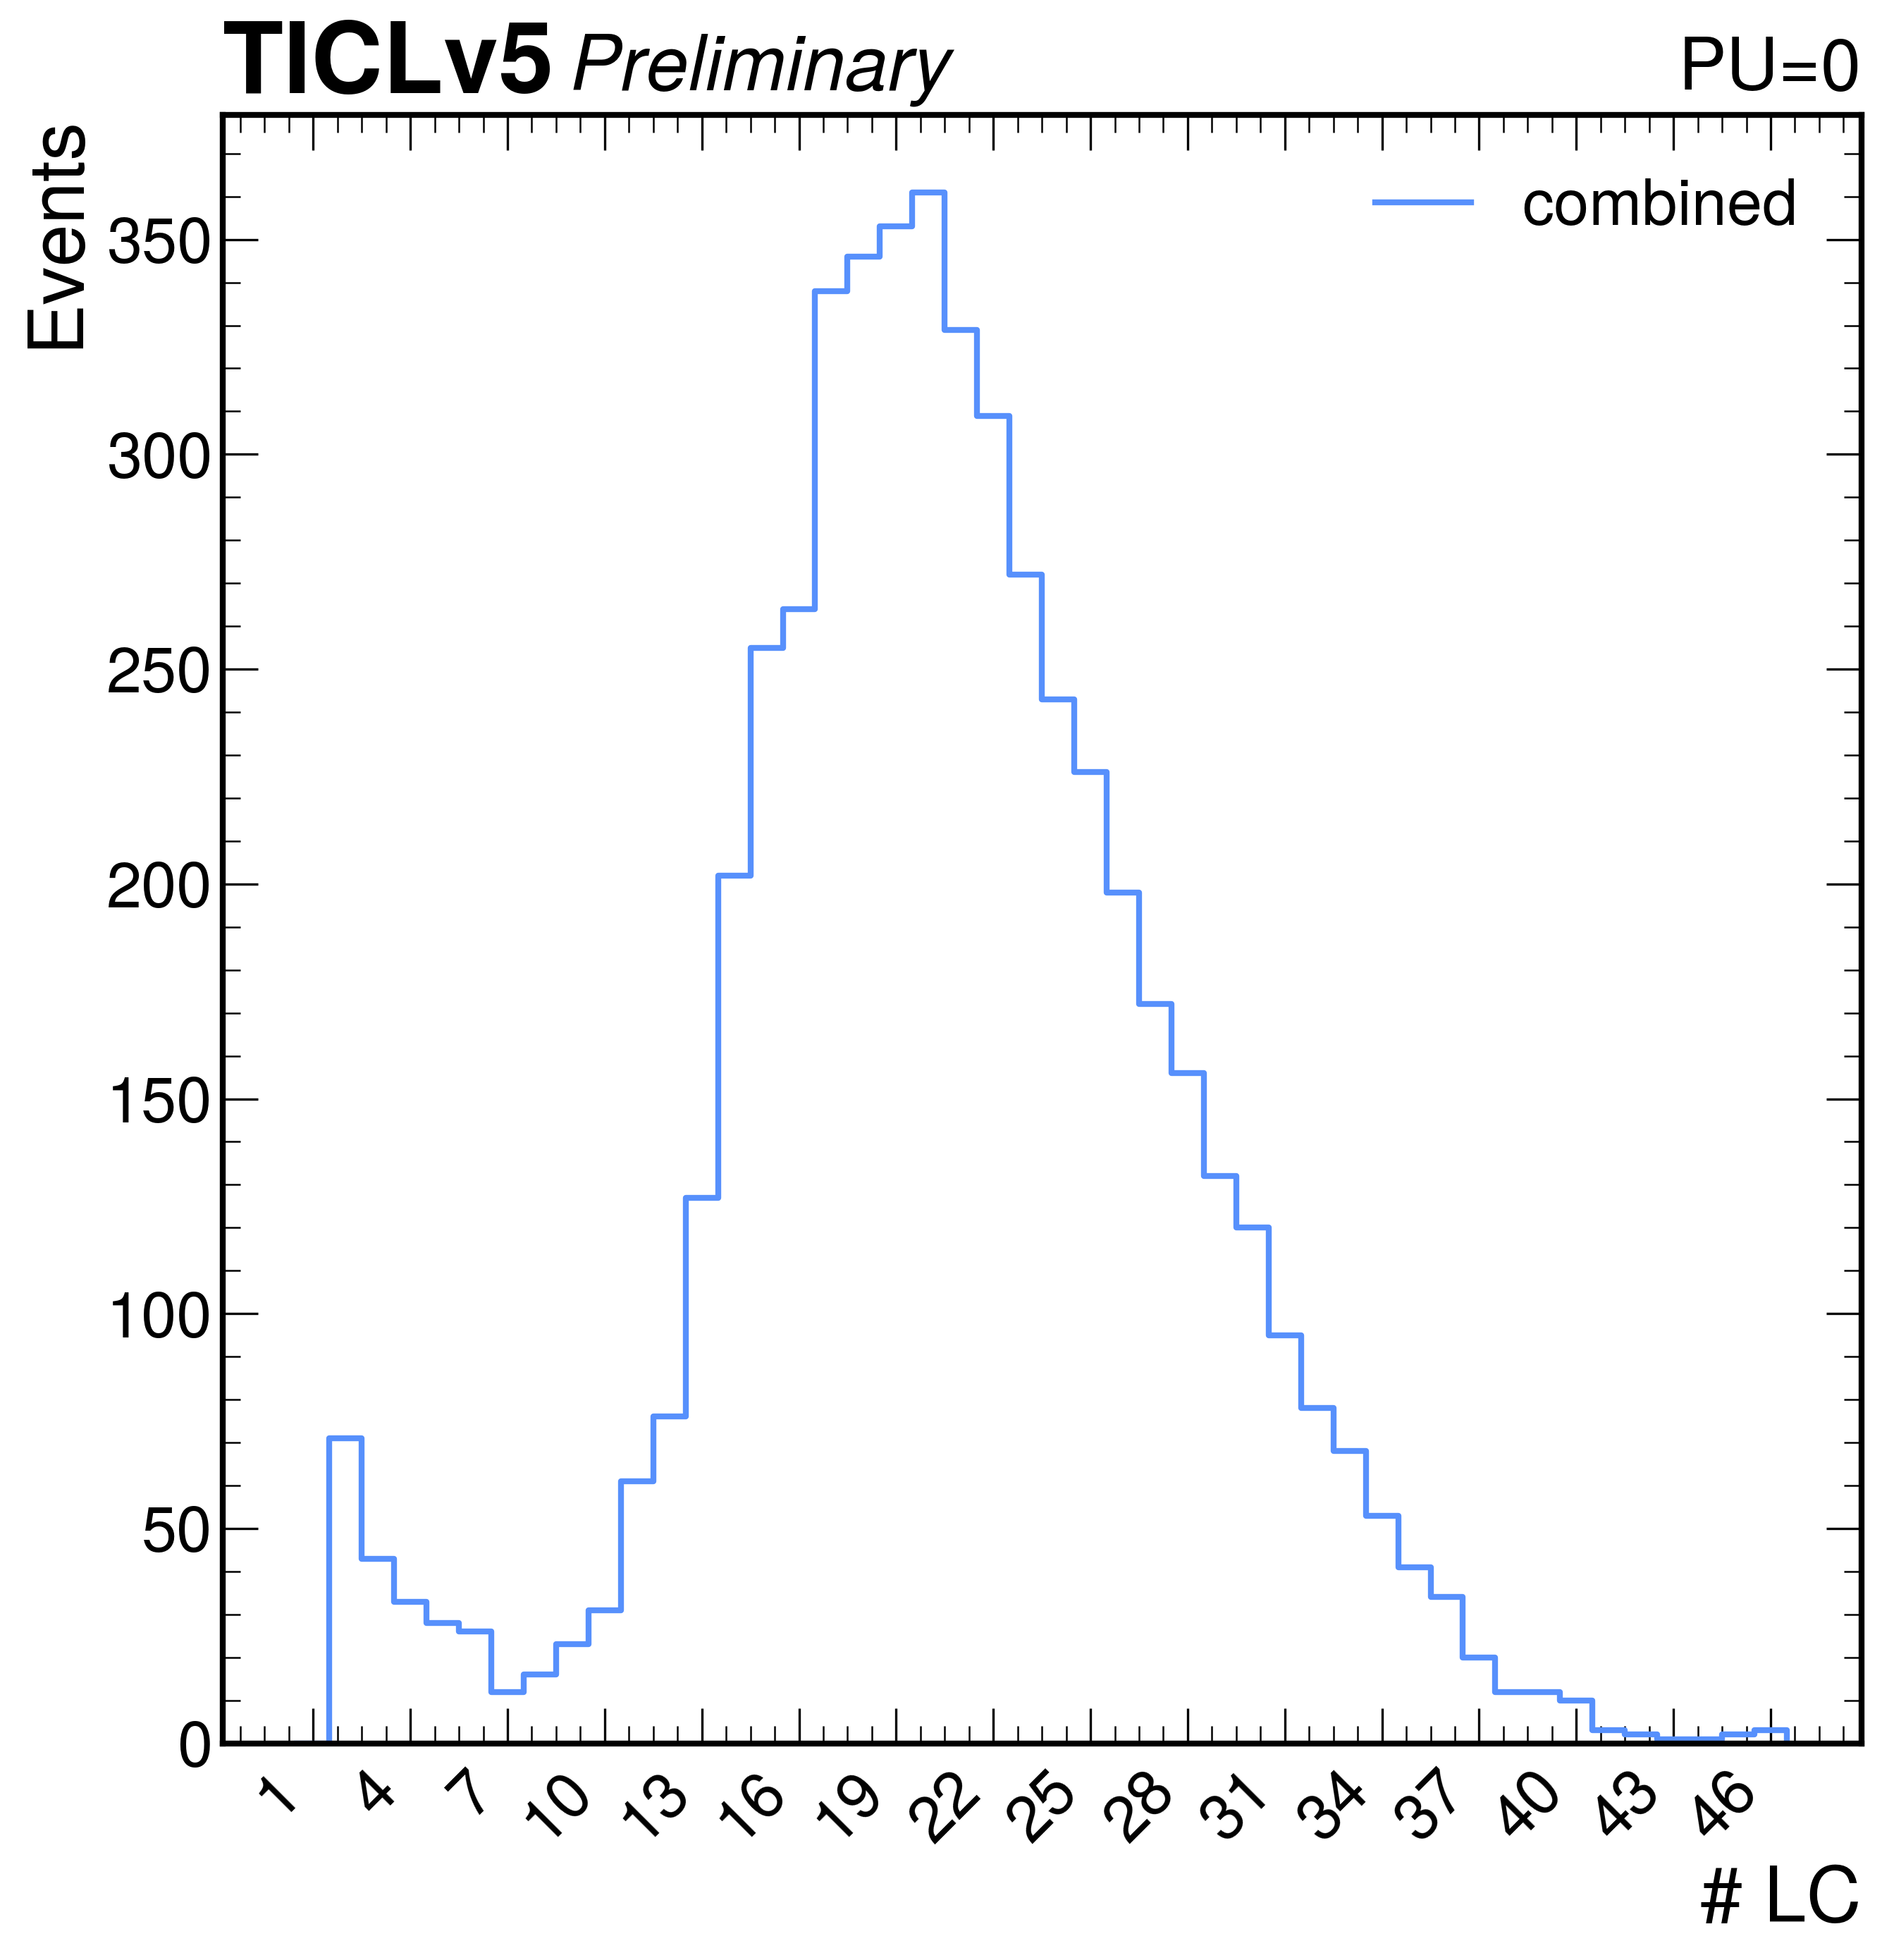

In [61]:
# Combined LC multiplicity plot
nbins = np.max(multiplicity)
bin_edges = np.linspace(1, nbins, nbins)
makePlot(hist_comb, bin_edges, 'LC', 'combined')

In [ ]:
# Plot LC multiplicity in each eta, energy and pT bin separately.

plotting_dict = {
    0: r'$\eta$',
    1: 'E', 
    2: r'$p_T$'
}

for i, edges_array in enumerate(edges):
    for bin in range(len(edges_array) - 1):
        min_bin = edges_array[bin]
        max_bin = edges_array[bin + 1]
        bin_var = plotting_dict[i]
        map_label = rf'{min_bin:.2f} < {bin_var} < {max_bin:.2f}'

        makePlot(hist_in_bins[i][0][bin], hist_in_bins[i][1][bin], 'LC', map_label)

In [ ]:
# Plot LC multiplicity in bins of eta, energy and pT on the same canvas.
plotting_dict = {
    0: r'$\eta$',
    1: 'E', 
    2: r'$p_T$'
}

for i, edges_array in enumerate(edges):
    fig, ax = plt.subplots()
    for bin in range(len(edges_array) - 1):
        min_bin = edges_array[bin]
        max_bin = edges_array[bin + 1]
        bin_var = plotting_dict[i]
        map_label = rf'{min_bin:.2f} < {bin_var} < {max_bin:.2f}'
        bin_centers = ((bin_edges_per_var[i][1:] + bin_edges_per_var[i][:-1])/2)
        
        bins_lc = np.repeat(bin_edges_per_var[i], 2)
        hist_lc = np.concatenate([[0], np.repeat(norm_hist_in_bins[i][0][bin], 2), [0]])

        ax.step(bins_lc, hist_lc, linewidth=2, label=map_label, where='post')

        ax.set_xticks(bin_centers[1::3], labels=range(1, len(bin_centers) , 3), rotation=45, ha='right')
        ax.set_xlabel('# LC')
        ax.set_ylabel('Events')
        ax.legend()
        hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
        hep.cms.lumitext("PU=0", ax=ax)
        hist_name = bin_var.replace('$', '').replace('\\', '')
        path_to_save = f'plots/multiplicity/LC'
        os.makedirs(path_to_save, exist_ok=True)
        #plt.savefig(f'{path_to_save}/{hist_name}.png')

### Data processing for nTrackster

In [65]:
# Extract data
seed_barycenter_eta = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="barycenter_eta"))
seed_energy = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="raw_energy"))
seed_pt = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="raw_pt"))

ntracksters = np.array(tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="NTracksters"))

# Find boundary values for eta, energy and pT
s_eta_max = np.max(seed_barycenter_eta)
s_eta_min = np.min(seed_barycenter_eta)
s_e_max = np.max(seed_energy)
s_e_min = np.min(seed_energy)
s_pt_max = np.max(seed_pt)
s_pt_min = np.min(seed_pt)

# Define eta binning
s_eta_nbins = 3
s_eta_edges = np.linspace(s_eta_min, s_eta_max, s_eta_nbins + 1)

# Define energy binning
s_e_nbins = 3
s_e_edges = np.linspace(s_e_min, s_e_max, s_e_nbins + 1)

# Define pT binning
s_pt_nbins = 3
s_pt_edges = np.logspace(np.log10(s_pt_min + 1), np.log10(s_pt_max), s_pt_nbins + 1)

# combine edges [eta, e, pt]
s_edges = [s_eta_edges, s_e_edges, s_pt_edges]

# combine multiplicity data in bins of [eta, e, pt]
ntracksters_in_bins = [[], [], []]

s_binning_data = {
    0: seed_barycenter_eta,
    1: seed_energy,
    2: seed_pt
}

for i, edges_array in enumerate(s_edges):
    for bin in range(len(edges_array) - 1):
        bin_map = np.array((s_binning_data[i] > edges_array[bin]) & (s_binning_data[i] < edges_array[bin + 1]))
        ntracksters_in_bins[i].append(ntracksters[bin_map])

# making histograms
nbins = np.max(ntracksters)
bin_edges = np.linspace(1, nbins, nbins)
hist_comb, _ = np.histogram(ntracksters, bin_edges)

hist_in_bins = [[[], []], [[], []], [[], []]]           # List of shape (3, 2, var), 3 = binning variables (eta, energy, pt), 2 = (hist, hist_bin_edges), var = number of bins in each binning variable

# Create binning for each variable [eta, energy, pT]
bin_edges_per_var = []
for i, edges_array in enumerate(s_edges):
    nbins = 0
    for bin in range(len(edges_array) - 1):
        nbins_cand = np.max(ntracksters_in_bins[i][bin])
        if nbins_cand > nbins:
            nbins = nbins_cand
    bin_edges = np.linspace(1, nbins, nbins)
    bin_edges_per_var.append(bin_edges)


for i, edges_array in enumerate(s_edges):
    bin_edges = bin_edges_per_var[i]
    for bin in range(len(edges_array) - 1):
        hist_per_bin, _ = np.histogram(ntracksters_in_bins[i][bin], bin_edges)
        hist_in_bins[i][0].append(hist_per_bin)
        hist_in_bins[i][1].append(bin_edges)

norm_hist_in_bins = [[[], []], [[], []], [[], []]]
for i, var in enumerate(hist_in_bins):
    hists = var[0]
    n_events_per_hist = np.array([np.sum(h) for h in hists])
    weights = n_events_per_hist[0]/n_events_per_hist

    norm_hists = [hists[i]*weights[i] for i in range(len(weights))]
    for h in norm_hists:
        norm_hist_in_bins[i][0].append(h)
    for b in var[1]:
        norm_hist_in_bins[i][1].append(b)


### Plotting nTracksters

In [ ]:
# Combined Tracksters multiplicity plot
nbins = np.max(ntracksters)
bin_edges = np.linspace(1, nbins, nbins)
makePlot(hist_comb, bin_edges, 'Tracksters', 'combined')

In [ ]:
plotting_dict = {
    0: r'$\eta_\text{seed}$',
    1: r'E$_\text{seed}$', 
    2: r'$\left(p_T \right)_\text{seed}$'
}

for i, edges_array in enumerate(s_edges):
    for bin in range(len(edges_array) - 1):
        min_bin = edges_array[bin]
        max_bin = edges_array[bin + 1]
        bin_var = plotting_dict[i]
        map_label = rf'{min_bin:.2f} < {bin_var} < {max_bin:.2f}'

        makePlot(hist_in_bins[i][0][bin], hist_in_bins[i][1][bin], 'Tracksters', map_label)

In [ ]:
# Plot LC multiplicity in bins of eta, energy and pT on the same canvas.
plotting_dict = {
    0: r'$\eta$',
    1: 'E', 
    2: r'$p_T$'
}

for i, edges_array in enumerate(s_edges):
    fig, ax = plt.subplots()
    for bin in range(len(edges_array) - 1):
        min_bin = edges_array[bin]
        max_bin = edges_array[bin + 1]
        bin_var = plotting_dict[i]
        map_label = rf'{min_bin:.2f} < {bin_var} < {max_bin:.2f}'
        bin_centers = ((bin_edges_per_var[i][1:] + bin_edges_per_var[i][:-1])/2)
        
        bins_tracksters = np.repeat(bin_edges_per_var[i], 2)
        hist_tracksters = np.concatenate([[0], np.repeat(norm_hist_in_bins[i][0][bin], 2), [0]])

        ax.step(bins_tracksters, hist_tracksters, linewidth=2, label=map_label, where='post')

        ax.set_xticks(bin_centers, labels=range(1, len(bin_centers) + 1))
        ax.set_xlabel('# Tracksters')
        ax.set_ylabel('Events')
        ax.set_ylim(0)
        ax.legend()
        hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
        hep.cms.lumitext("PU=0", ax=ax)
        hist_name = bin_var.replace('$', '').replace('\\', '')
        path_to_save = f'plots/multiplicity/LC'
        os.makedirs(path_to_save, exist_ok=True)
        #plt.savefig(f'{path_to_save}/{hist_name}.png')

### Data processing for multiplicity in Superclusters

In [71]:
# Extract data
seed_barycenter_eta = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="barycenter_eta"))
seed_energy = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="raw_energy"))
seed_pt = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="raw_pt"))
nsuperclusters = ak.num(tfile.openArray(branch_name="ticlDumper/trackstersTiclCandidate", key="vertices_z"))

# Find boundary values for eta, energy and pT
s_eta_max = np.max(seed_barycenter_eta)
s_eta_min = np.min(seed_barycenter_eta)
s_e_max = np.max(seed_energy)
s_e_min = np.min(seed_energy)
s_pt_max = np.max(seed_pt)
s_pt_min = np.min(seed_pt)

# Define eta binning
s_eta_nbins = 3
s_eta_edges = np.linspace(s_eta_min, s_eta_max, s_eta_nbins + 1)

# Define energy binning
s_e_nbins = 3
s_e_edges = np.linspace(s_e_min, s_e_max, s_e_nbins + 1)

# Define pT binning
s_pt_nbins = 3
s_pt_edges = np.logspace(np.log10(s_pt_min + 1), np.log10(s_pt_max), s_pt_nbins + 1)

# combine edges [eta, e, pt]
s_edges = [s_eta_edges, s_e_edges, s_pt_edges]

# combine multiplicity data in bins of [eta, e, pt]
nsuperclusters_in_bins = [[], [], []]

s_binning_data = {
    0: seed_barycenter_eta,
    1: seed_energy,
    2: seed_pt
}

for i, edges_array in enumerate(s_edges):
    for bin in range(len(edges_array) - 1):
        bin_map = np.array((s_binning_data[i] > edges_array[bin]) & (s_binning_data[i] < edges_array[bin + 1]))
        nsuperclusters_in_bins[i].append(nsuperclusters[bin_map])

# making histograms
nbins = np.max(ntracksters)
bin_edges = np.linspace(1, nbins, nbins)
hist_comb, _ = np.histogram(ntracksters, bin_edges)

hist_in_bins = [[[], []], [[], []], [[], []]]           # List of shape (3, 2, var), 3 = binning variables (eta, energy, pt), 2 = (hist, hist_bin_edges), var = number of bins in each binning variable

# Create binning for each variable [eta, energy, pT]
bin_edges_per_var = []
for i, edges_array in enumerate(s_edges):
    nbins = 0
    for bin in range(len(edges_array) - 1):
        nbins_cand = np.max(nsuperclusters_in_bins[i][bin])
        if nbins_cand > nbins:
            nbins = nbins_cand
    bin_edges = np.linspace(1, nbins, nbins)
    bin_edges_per_var.append(bin_edges)


for i, edges_array in enumerate(s_edges):
    bin_edges = bin_edges_per_var[i]
    for bin in range(len(edges_array) - 1):
        hist_per_bin, _ = np.histogram(nsuperclusters_in_bins[i][bin], bin_edges)
        hist_in_bins[i][0].append(hist_per_bin)
        hist_in_bins[i][1].append(bin_edges)

norm_hist_in_bins = [[[], []], [[], []], [[], []]]
for i, var in enumerate(hist_in_bins):
    hists = var[0]
    n_events_per_hist = np.array([np.sum(h) for h in hists])
    weights = n_events_per_hist[0]/n_events_per_hist

    norm_hists = [hists[i]*weights[i] for i in range(len(weights))]
    for h in norm_hists:
        norm_hist_in_bins[i][0].append(h)
    for b in var[1]:
        norm_hist_in_bins[i][1].append(b)


### Plotting Superclusters multiplicity

In [ ]:
# Combined Tracksters multiplicity plot
nbins = np.max(nsuperclusters)
bin_edges = np.linspace(1, nbins, nbins)
makePlot(hist_comb, bin_edges, 'Superclusters', 'combined')

In [ ]:
plotting_dict = {
    0: r'$\eta_\text{seed}$',
    1: r'E$_\text{seed}$', 
    2: r'$\left(p_T \right)_\text{seed}$'
}

for i, edges_array in enumerate(s_edges):
    for bin in range(len(edges_array) - 1):
        min_bin = edges_array[bin]
        max_bin = edges_array[bin + 1]
        bin_var = plotting_dict[i]
        map_label = rf'{min_bin:.2f} < {bin_var} < {max_bin:.2f}'

        makePlot(hist_in_bins[i][0][bin], hist_in_bins[i][1][bin], 'Superclusters', map_label)

In [ ]:
# Plot Superclusters multiplicity in bins of eta, energy and pT on the same canvas.
plotting_dict = {
    0: r'$\eta$',
    1: 'E', 
    2: r'$p_T$'
}

# Create binning for each variable [eta, energy, pT]
for i, edges_array in enumerate(s_edges):
    fig, ax = plt.subplots()
    for bin in range(len(edges_array) - 1):
        min_bin = edges_array[bin]
        max_bin = edges_array[bin + 1]
        bin_var = plotting_dict[i]
        map_label = rf'{min_bin:.2f} < {bin_var} < {max_bin:.2f}'
        bin_centers = ((bin_edges_per_var[i][1:] + bin_edges_per_var[i][:-1])/2)
        
        bins_tracksters = np.repeat(bin_edges_per_var[i], 2)
        hist_tracksters = np.concatenate([[0], np.repeat(norm_hist_in_bins[i][0][bin], 2), [0]])

        ax.step(bins_tracksters, hist_tracksters, linewidth=2, label=map_label, where='post')

        ax.set_xticks(bin_centers, labels=range(1, len(bin_centers) + 1))
        ax.set_xlabel('# Superclusters')
        ax.set_ylabel('Events')
        ax.set_ylim(0)
        ax.legend()
        hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
        hep.cms.lumitext("PU=0", ax=ax)
        hist_name = bin_var.replace('$', '').replace('\\', '')
        path_to_save = f'plots/multiplicity/LC'
        os.makedirs(path_to_save, exist_ok=True)
        #plt.savefig(f'{path_to_save}/{hist_name}.png')